Resources:

- [cifar10 (Colab)](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=ubQdOyR6FjUB)

- [Iterative Pruning (Colab)](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

- [Pruning Experiments (Github)](https://github.com/olegpolivin/pruningExperiments/tree/main)
- [Pruning Experiments (Medium)](https://olegpolivin.medium.com/experiments-in-neural-network-pruning-in-pytorch-c18d5b771d6d)
- [Sparsifying Regularizer (Github)](https://github.com/dizam92/pyTorchReg)

Components
- data loading + preprocessing (/utils/data_utils.py ??)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from regularizers.regularizer import L1Regularizer

import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'torch'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# -> /utils/data_utils.py

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse horse  deer  frog


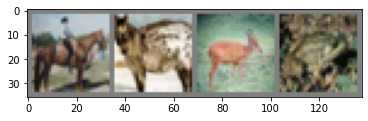

In [5]:
# -> utils/evaluation_utils.py

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
# -> /models/model.py

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# ISOLATE TRAINING LOOP

def training_loop(inputs,labels,regularizer_loss=None) -> "loss":
    # get the inputs
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # REGULARIZATION
    if regularizer_loss:
        loss = regularizer_loss.regularized_all_param(reg_loss_function=loss)

    loss.backward()
    optimizer.step()

    return loss

In [11]:
num_of_regularizers = 2

list_of_models = [Net()]*num_of_regularizers
list_of_regularizers = [None,L1Regularizer(model=list_of_models[1], lambda_reg=10**-2)]

In [23]:
# 1 training cycle for ALL regularizers
# 1 epoch, 1 data point
# for every epoch:
# for every data point:

data1 = next(dataiter)
# net.to(device)

inputs, labels = data1
# inputs, labels = inputs.to(device), labels.to(device) # GPU

def calculate_loss_for_all_regularizers(inputs,labels):

    loss_across_regularizers = []

    for regularizer_index,regularizer in enumerate(list_of_regularizers):
        loss = training_loop(inputs,labels,regularizer)
        loss_across_regularizers.append(loss.item())

    loss_across_epochs.append(loss_across_regularizers)
    # print(loss_across_regularizers)

In [24]:
# -> utils/training_utils.py
# net.to(device)


# TRAINING CHANNEL

loss_across_epochs = []

for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # limit training time for debugging purposes
        if i > 5:
            break
        calculate_loss_for_all_regularizers(inputs,labels)
        # calculate_FLOPS()
        # calculate_latency()
        print(i)

print('Finished Training')

0
1
2
3
4
5
Finished Training


In [ ]:
# CALC NUMBER OF FLOPS PER MODEL
# need model (net) and input

def calculate_FLOPS(model, input):
    from thop import profile

    flops, params  = profile(model.eval(),  inputs= input)

    return flops


In [25]:
print(loss_across_epochs)

[[2.278592348098755, 184.9903106689453], [2.2759764194488525, 184.9867706298828], [2.2715847492218018, 184.98158264160156], [2.2656683921813965, 184.97500610351562], [2.25850772857666, 184.96731567382812], [2.250317335128784, 184.9586639404297]]


In [26]:
import pandas as pd

In [37]:
columns=["No Regularizer","L1 Regularizer"]
df = pd.DataFrame(loss_across_epochs, columns=columns)
print(df)

   No Regularizer  L1 Regularizer
0        2.278592      184.990311
1        2.275976      184.986771
2        2.271585      184.981583
3        2.265668      184.975006
4        2.258508      184.967316
5        2.250317      184.958664


In [42]:
df = pd.DataFrame({'length': [1.5, 0.5, 1.2, 0.9, 3],
                  'width': [0.7, 0.2, 0.15, 0.2, 1.1]},
                  index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])
df

,length,width
pig,1.5,0.70
rabbit,0.5,0.20
duck,1.2,0.15
chicken,0.9,0.20
horse,3.0,1.10


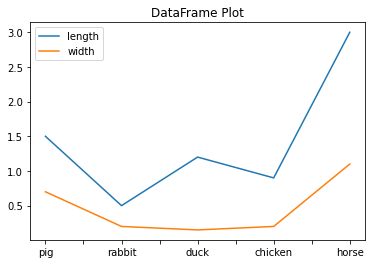

In [40]:
df = pd.DataFrame({'length': [1.5, 0.5, 1.2, 0.9, 3],
                  'width': [0.7, 0.2, 0.15, 0.2, 1.1]},
                  index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])
plot = df.plot(title="DataFrame Plot")

GroundTruth:    cat  ship  ship plane


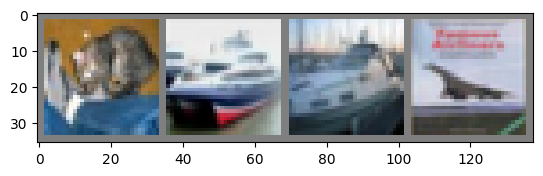

In [45]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  deer   car plane


In [47]:
# -> utils/evaluation_utils.py

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [20]:
# -> utils/evaluation_utils.py

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 60 %
Accuracy of  bird : 14 %
Accuracy of   cat : 21 %
Accuracy of  deer : 62 %
Accuracy of   dog : 54 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 54 %
Accuracy of truck : 65 %
